# Importing

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import cv2
import numpy as np
import easyocr
from paddleocr import PaddleOCR
import matplotlib.pyplot as plt
import pandas as pd
from concurrent.futures import ThreadPoolExecutor, as_completed
import os


# TOOL

In [ ]:


class Processing:
    def __init__(self, num_threads=4):
        self.reader = easyocr.Reader(['vi'], verbose=False)
        self.paddle_reader = PaddleOCR(lang='en', show_log=False)
        self.num_threads = num_threads

    def find_rects_texts(self, img_path, mode_draw=0):
        image = cv2.imread(img_path)
        img = image.copy()

        h, w = image.shape[:2]
        image_resized = cv2.resize(image, (int(w * 2.4), int(h * 1.2)))
        result = self.paddle_reader.ocr(image_resized, cls=True)[0]

        rects, horizontal_list, texts = [], [], []

        for line in result:
            box = np.array(line[0], dtype=np.float32)
            x, y, w, h = cv2.boundingRect(box)
            x1, y1 = int(x / 2.4), int(y / 1.2)
            x2, y2 = int((x + w) / 2.4), int((y + h) / 1.2)

            rects.append([x1, y1, x2, y2])
            horizontal_list.append([x1, x2, y1, y2])

        rects = np.array(rects, dtype=int)
        results = self.reader.recognize(img, horizontal_list=horizontal_list, free_list=[])

        for _, text, _ in results:
            text = text.strip()
            if text == '1.': text = 'I.'
            elif text == '11.': text = 'II.'
            else:
                chars = list(text)
                for i in range(1, len(chars)):
                    if chars[i] == '1' and chars[i - 1] == 'I':
                        chars[i] = 'I'
                text = ''.join(chars)
            texts.append(text)

        if mode_draw:
            for rect in rects:
                cv2.rectangle(img, (rect[0], rect[1]), (rect[2], rect[3]), (0, 255, 0), 1)
            plt.figure(figsize=(12, 12))
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            plt.axis('off')
            plt.show()

        return rects, texts

    def check_line(self, box1, box2):
        return abs((box1[1] + box1[3]) // 2 - (box2[1] + box2[3]) // 2) < 10

    def rects_texts_ncollum_processed(self, rects, texts):
        rects_new, txts_new = [], []
        current_rect, current_txt = [], []
        max_col = 0

        for i, text in enumerate(texts):
            text = text.strip()
            if not text: 
                continue
            if text[0].isdigit() and text[-1].isdigit():
                text = text.replace(',', '.')

            if not current_rect or self.check_line(current_rect[-1], rects[i]):
                current_rect.append(rects[i])
                current_txt.append(text)
            else:
                combined = sorted(zip(current_rect, current_txt), key=lambda x: (x[0][0] + x[0][2]) // 2)
                cur_rect_sorted, cur_txt_sorted = zip(*combined)
                rects_new.append(np.array(cur_rect_sorted))
                txts_new.append(list(cur_txt_sorted))
                max_col = max(max_col, len(cur_txt_sorted))
                current_rect = [rects[i]]
                current_txt = [text]

        if current_rect:
            combined = sorted(zip(current_rect, current_txt), key=lambda x: (x[0][0] + x[0][2]) // 2)
            cur_rect_sorted, cur_txt_sorted = zip(*combined)
            rects_new.append(np.array(cur_rect_sorted))
            txts_new.append(list(cur_txt_sorted))
            max_col = max(max_col, len(cur_txt_sorted))

        return rects_new, txts_new, max_col

    def find_box_cols(self, rects_box, n_cols):
        cols_data = [row[:, [0, 2]].flatten() for row in rects_box if len(row) == n_cols]
        cols_data = np.array(cols_data)

        col_xmin = cols_data[:, ::2].min(axis=0)
        col_xmax = cols_data[:, 1::2].max(axis=0)

        return np.stack((col_xmin, col_xmax), axis=1)

    def find_text_each_row(self, box_cols, list_rects, list_texts):
        result = []
        for row_rects, row_texts in zip(list_rects, list_texts):
            row_data = [''] * len(box_cols)
            for rect, text in zip(row_rects, row_texts):
                x_center = (rect[0] + rect[2]) // 2
                for idx, (xmin, xmax) in enumerate(box_cols):
                    if xmin <= x_center <= xmax:
                        row_data[idx] = (row_data[idx] + ' ' + text).strip() if row_data[idx] else text
                        break
            result.append(row_data)
        return result

    def process_single_image(self, img_path, draw=0):
        rects, texts = self.find_rects_texts(img_path, draw)
        rects_grouped, texts_grouped, n_cols = self.rects_texts_ncollum_processed(rects, texts)
        box_cols = self.find_box_cols(rects_grouped, n_cols)
        return self.find_text_each_row(box_cols, rects_grouped, texts_grouped)

    

    def processing(self, img_paths):
        if isinstance(img_paths, str):
            img_paths = [img_paths]

        results_all = []

        with ThreadPoolExecutor(max_workers=self.num_threads) as executor:
            futures = {
                executor.submit(self.process_single_image, path, draw = 0): path
                for path in img_paths
            }

            for future in as_completed(futures):
                img_path = futures[future]
                try:
                    result = future.result()
                    results_all.append(result)

                    # Nếu bật chế độ xuất CSV
                    df = pd.DataFrame(result)
                    out_file = os.path.splitext(img_path)[0] + '.csv'
                    df.to_csv(out_file, index=False, header=False)
                    print(f"✅ Output CSV saved to: {out_file}")

                except Exception as e:
                    print(f"❌ Error processing {img_path}: {e}")
        
        return results_all

        # flat_data = []
        # if mode == 0:
        #     # Gộp nguyên dạng từng bảng (giữ nguyên số cột mỗi dòng)
        #     for table in results_all:
        #         flat_data.extend(table)
        #         flat_data.append([''] * len(table[0]))  # dòng trống phân tách bảng
        # else:
        #     # Làm phẳng thành bảng chuẩn hóa
        #     max_cols = max(len(row) for table in results_all for row in table)
        #     for table in results_all:
        #         for row in table:
        #             flat_data.append(row + [''] * (max_cols - len(row)))

        # df = pd.DataFrame(flat_data)
        # df.to_csv(output_csv, index=False, header=False)
        # print(f"✅ Output CSV saved to: {output_csv}")
        # return df


In [22]:
tool = Processing()

[2025/04/15 03:26:38] ppocr WARNING: Since the angle classifier is not initialized, it will not be used during the forward process


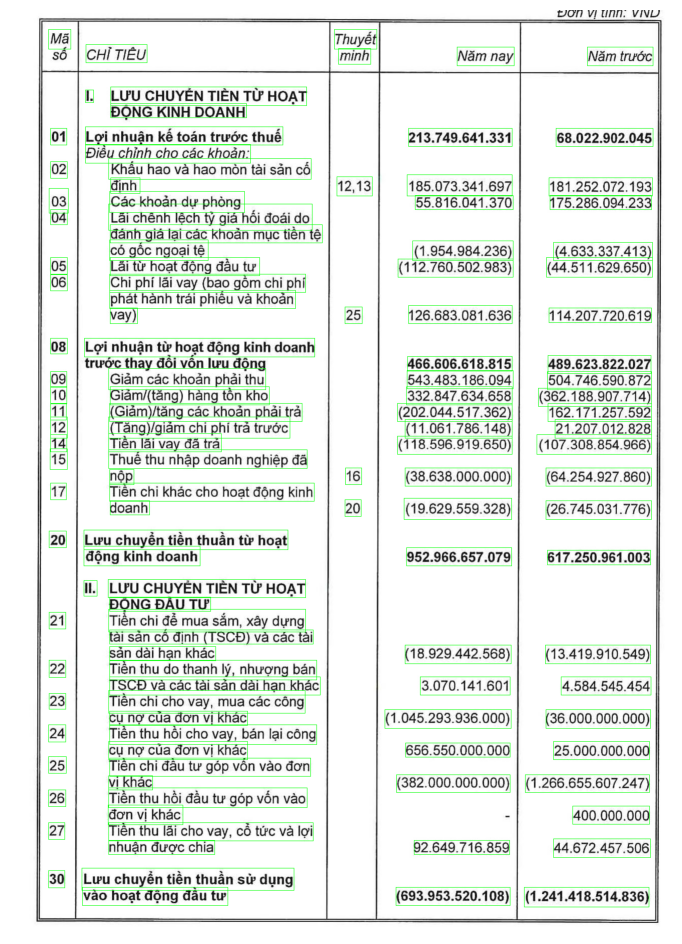

,0,1,2,3
0,Mã,Thuyết,,
1,CHỈ TIÊU,minh,Năm nay,Năm trước
2,1,LƯU CHUYÉN TIÈN TỪ HOẠT,,
3,,ĐÔNG KINH DOANH,,
4,01,Lợi nhuận kế toán trước thuế,213.749.641.331,68.022.902.045
5,,Điều chỉnh cho các khoản:,,
6,02,Khấu hao và hao mòn tài sản cố,,
7,định,12.13,185.073.341.697,181.252.072.193
8,03,Các khoản dự phòng,55.816.041.370,175.286.094.233
9,04,Lãi chênh lệch tỷ gia hối đoái do,,


In [ ]:
path = r'G:\vietnamese-ocr\test\9.png'
a = tool.process_single_image(img_path= path, draw= 1)
df = pd.DataFrame(a)
df                                      

In [ ]:
import os

img_dir = 'test'
img_paths = [os.path.join(img_dir, fname) for fname in os.listdir(img_dir)]
a = tool.processing(img_paths, draw=1)


In [14]:
df = pd.DataFrame(a)
df.to_excel('out.xlsx')

In [9]:
# path = r'test.png'
class Processing:
    def __init__(self):
        self.reader = easyocr.Reader(['vi'], verbose=False)
        
    def find_rects_texts(self, img_path, mode_draw = 1):
        paddle_reader = PaddleOCR(lang='en', show_log=False)

        image = cv2.imread(img_path)
        # hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

        # lower_red = np.array([0, 18, 110])  # H: 169-175, S: 53-159, V: 134-255
        # upper_red = np.array([180, 255, 255])

        # # Lọc vùng đỏ trong ảnh
        # mask = cv2.inRange(hsv, lower_red, upper_red)

        # # Biến vùng đỏ thành trắng trong ảnh gốc
        # image[mask > 0] = [255, 255, 255]

        # # Làm mờ nhẹ để giảm nhiễu (Gaussian blur)
        # blurred = cv2.GaussianBlur(gray, (3, 3), 0)

        # # Tăng tương phản bằng histogram equalization
        # equalized = cv2.equalizeHist(blurred)

        # # Adaptive thresholding để phân vùng rõ chữ
        # thresh = cv2.adaptiveThreshold(
        #     equalized, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        #     cv2.THRESH_BINARY_INV, 21, 10
        # )

        # # Loại bỏ nhiễu nhỏ bằng morphological operations
        # kernel = np.ones((1, 1), np.uint8)
        # processed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

        # image = processed.copy()
        img = image.copy()

        w, h = image.shape[:2]
        image = cv2.resize(image, (int(h * 2.4), int(w * 1.2)))

        # Chạy OCR để detect box
        result = paddle_reader.ocr(image, cls = True)

        result = result[0]

        boxes = [line[0] for line in result]
        rects = []
        horizontal_list = []
        texts = []


        for box in boxes:
            box = np.array(box, dtype=np.float32)
            x, y, w, h = cv2.boundingRect(box)

            # Tọa độ đã scale
            x1 = int(x / 2.4)
            y1 = int(y / 1.2)
            x2 = int((x + w) / 2.4)
            y2 = int((y + h) / 1.2)

            rects.append([x1, y1, x2, y2])
            horizontal_list.append([x1, x2, y1, y2])

        rects = np.array(rects, dtype=int)


        results = self.reader.recognize(img, horizontal_list=horizontal_list, free_list=[])


        for box, text, confidence in results:
            chars = list(text)  # Tách text thành danh sách ký tự
            for i in range(1, len(chars)):
                if chars[i] == '1' and chars[i - 1] == 'I':
                    chars[i] = 'I'
            text = ''.join(chars)
            if text == '1.':
                text = 'I.'
            elif text == '11.':
                text = 'II.'
            texts.append(text)
        if mode_draw:
            for rect in rects:
                x1, y1, x2, y2 = rect
                cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)

            plt.figure(figsize=(12, 12))
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            plt.axis('off')
            plt.show()
        # rect in rects is [x1, y1, x2, y2]
        return rects, texts
    def check_line(sefl, box1, box2):
        if abs((box1[1] + box1[3]) // 2 - (box2[1] + box2[3]) // 2) < 10:
            return True
        return False

    def rects_texts_ncollum_processed(self, rects, texts):
        rects_new = []
        txts_new = []

        current_rect = []
        current_txt = []

        max_collum= 0

        for i in range(len(texts)):
            texts[i] = texts[i].strip()
            if(texts[i] == ''):
                continue

            if texts[i][0].isdigit() and texts[i][-1].isdigit():
                texts[i] = texts[i].replace(',', '.')

            if len(current_rect) == 0:
                current_rect.append(rects[i])
                current_txt.append(texts[i])
            else:
                if self.check_line(current_rect[-1], rects[i]):
                    current_rect.append(rects[i])
                    current_txt.append(texts[i])
                    
                    # print(current_txt)
                else:
                    for x in range(len(current_rect)):
                        for y in range(x + 1, len(current_rect)):
                            x_cen_x = (current_rect[x][0] + current_rect[x][2]) // 2
                            x_cen_y = (current_rect[y][0] + current_rect[y][2]) // 2
                            
                            if x_cen_x > x_cen_y:
                                current_rect[x], current_rect[y] = current_rect[y], current_rect[x]
                                current_txt[x], current_txt[y] = current_txt[y], current_txt[x] 
                    current_rect = np.array(current_rect)
                    rects_new.append(current_rect)
                    txts_new.append(current_txt)
                    
                    max_collum = max(max_collum, len(current_txt))
                    
                    
                    current_rect = [rects[i]]
                    current_txt = [texts[i]]
                    
        if len(current_rect) > 0:
            for x in range(len(current_rect)):
                for y in range(x + 1, len(current_rect)):
                    x_cen_x = (current_rect[x][0] + current_rect[x][2]) // 2
                    x_cen_y = (current_rect[y][0] + current_rect[y][2]) // 2
                    
                    if x_cen_x > x_cen_y:
                        current_rect[x], current_rect[y] = current_rect[y], current_rect[x]
                        current_txt[x], current_txt[y] = current_txt[y], current_txt[x]

            current_rect = np.array(current_rect)
        
            rects_new.append(current_rect)
            txts_new.append(current_txt)
            
            max_collum = max(max_collum, len(current_txt))

            # rects_new = np.array(rects_new)
        return rects_new, txts_new, max_collum

    def find_text_each_row(self, box_cols, list_rects, list_texts):
        array_text_reconstructed = []
        n_cols = len(box_cols)
        
        # each row
        for id_rects in range(len(list_rects)):
            array_text_cur = [' '] * n_cols
            
            # each box in row
            for id_rect in range(len(list_rects[id_rects])):
                x1, y1, x2, y2 = list_rects[id_rects][id_rect]
                x_cen = (x1 + x2) // 2

                for id_cols in range(n_cols):
                    x_min_box_col, x_max_box_col = box_cols[id_cols]
        
                    if x_cen >= x_min_box_col and x_cen <= x_max_box_col:
                        if array_text_cur[id_cols] == ' ':
                            array_text_cur[id_cols] = list_texts[id_rects][id_rect]
                        else:
                            array_text_cur[id_cols] += ' ' + list_texts[id_rects][id_rect]
                
            array_text_reconstructed.append(array_text_cur)

        return array_text_reconstructed
    def find_box_cols(self, rects_box, n_cols):
        col_box_xmin_xmax = []
        for row in rects_box:
            if len(row) == n_cols:
                col_box_xmin_xmax.append(row[:, [True, False, True, False]].flatten())
        col_box_xmin_xmax = np.array(col_box_xmin_xmax)

        row_arg_min = np.argmin(col_box_xmin_xmax, axis= 0)
        row_arg_max = np.argmax(col_box_xmin_xmax, axis= 0)

        cols_index = np.arange(col_box_xmin_xmax.shape[1])
        
        # print(col_box_xmin_xmax)
        
        x_min_each_cols = np.expand_dims(col_box_xmin_xmax[row_arg_min, cols_index][::2], axis= 0).T
        x_max_each_cols = np.expand_dims(col_box_xmin_xmax[row_arg_max, cols_index][1:][::2], axis= 0).T

        return np.concatenate([x_min_each_cols, x_max_each_cols], axis= 1)

    def processing(self, img_path, mode_draw = 0):
        rects, texts = self.find_rects_texts(img_path= img_path, mode_draw= mode_draw)
        rects_restructed, texts_restructed, n_cols = self.rects_texts_ncollum_processed(rects= rects, texts= texts)
        box_xmin_xmax_each_col = self.find_box_cols(rects_box= rects_restructed, n_cols= n_cols)
        array_texts_restructed = self.find_text_each_row(box_cols= box_xmin_xmax_each_col, list_rects= rects_restructed, list_texts= texts_restructed)
        return array_texts_restructed

In [10]:
tool = Processing()

In [16]:
path = r'G:\vietnamese-ocr\test\9.png'

[2025/04/15 03:21:08] ppocr WARNING: Since the angle classifier is not initialized, it will not be used during the forward process


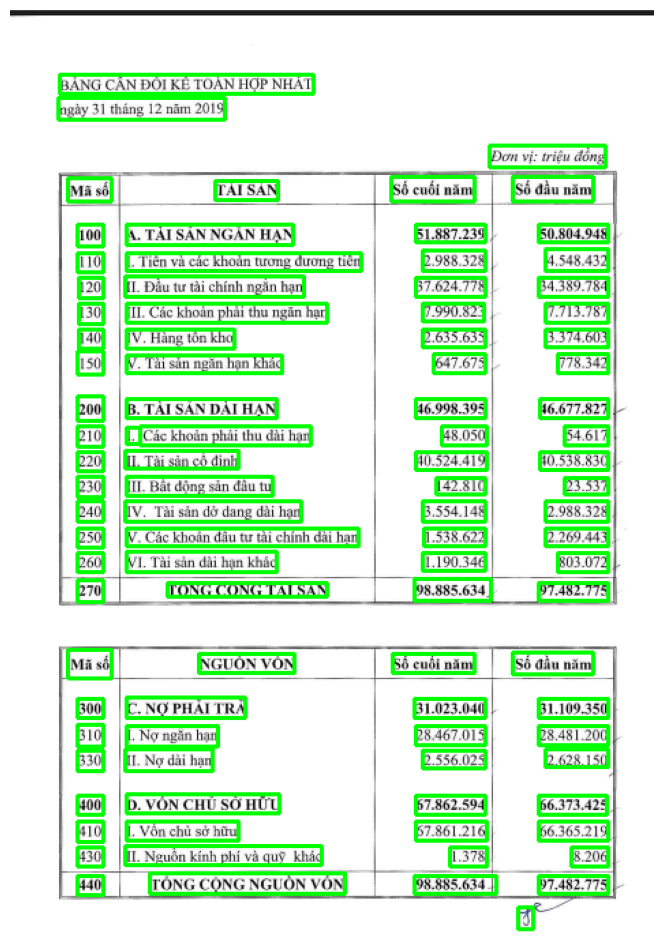

In [17]:
a = tool.processing(img_path= path, mode_draw= 1)

In [18]:
pd.DataFrame(a)

,0,1,2,3,4
0,,,BANG CÂN ĐÔIKÉTOÁN HỢP NH4I,,
1,,,ngày 31 tháng 12 nam 2015,,
2,,,,,
3,Mã sí,,TAI SAN,,
4,100,,A. TAI SÀN NGAN HẠN,51.887.239,50.804.948
5,110,,[ Tién và các khodn lưong duong tien,2.988 328,4.548.432
6,120,,IL Dau 1ư tài chính ngan han,37.624.776,34.389.784
7,[30,,"[IL, Cac khoun phaỉ thu ngun hụn",7.990.82-,7.713.787
8,140,,[V. Hàng ton khu,2.635.635,3.374.603
9,150,,V.Tai san ngán han khac,647.675,778.342


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Đọc ảnh gốc
image = cv2.imread(path)

# Resize nếu cần (tùy ảnh lớn nhỏ)
image = cv2.resize(image, (0, 0), fx=1.0, fy=1.0)

# Chuyển sang grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Làm mờ nhẹ để giảm nhiễu
blurred = cv2.GaussianBlur(gray, (3, 3), 0)

# Loại bỏ nhiễu nhỏ
kernel = np.ones((1, 1), np.uint8)
processed = cv2.morphologyEx(blurred, cv2.MORPH_CLOSE, kernel)

# ===== Hiển thị ảnh gốc và ảnh đã xử lý bằng matplotlib =====
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # Đổi BGR sang RGB để hiển thị đúng màu
plt.title('Ảnh gốc')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(processed, cmap='gray')
plt.title('Ảnh sau tiền xử lý')
plt.axis('off')

plt.tight_layout()
plt.show()


In [2]:
img_path = r"C:\Users\levie\OneDrive\Hình ảnh\Screenshots\Screenshot 2025-04-13 012509.png"
import cv2
import numpy as np

# Đọc ảnh
image = cv2.imread(img_path)

# Chuyển sang không gian màu HSV để lọc màu dễ hơn


# # Định nghĩa khoảng màu đỏ trong HSV
# lower_red1 = np.array([0, 70, 50])
# upper_red1 = np.array([10, 255, 255])
# lower_red2 = np.array([170, 70, 50])
# upper_red2 = np.array([250, 255, 255])

# # Tạo mask cho cả hai vùng đỏ (vì đỏ nằm ở đầu và cuối phổ màu HSV)
# mask1 = cv2.inRange(hsv, lower_red1, upper_red1)
# mask2 = cv2.inRange(hsv, lower_red2, upper_red2)
# red_mask = cv2.bitwise_or(mask1, mask2)
# Ngưỡng HSV cho màu đỏ



# 165 40 200
# 175 170 255
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

lower_red = np.array([0, 18, 110])  # H: 169-175, S: 53-159, V: 134-255
upper_red = np.array([180, 255, 255])

# Lọc vùng đỏ trong ảnh
mask = cv2.inRange(hsv, lower_red, upper_red)

# Biến vùng đỏ thành trắng trong ảnh gốc
image[mask > 0] = [255, 255, 255]

# Hiển thị kết quả
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB))
plt.title("Ảnh gốc")

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Đã loại bỏ vết đỏ")

plt.axis('off')
plt.tight_layout()
plt.show()


error: OpenCV(4.11.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:199: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


In [8]:
import easyocr

# Khởi tạo reader 1 lần ở ngoài
reader = easyocr.Reader(['vi'], gpu=False, verbose=False)

def recognize_from_img_cut(image, min_conf=0.5):
    try:
        results = reader.readtext(image)
    except Exception as e:
        print(f"Lỗi EasyOCR: {e}")
        return 
    res = ''
    for bbox, text, confidence in results:
        if confidence >= min_conf:
            res += text + " "
    return res.strip()


In [ ]:
import easyocr

reader = easyocr.Reader(['vi'], verbose= False)  # thêm 'en' để hỗ trợ cả tiếng Anh nếu cần
results = reader.readtext(r'C:\Users\levie\Downloads\ReportFinance\test1\00001646903820816864cng-ty-c-phn-cao-su-sao-vng01032024-101631\00001646903820816864cng-ty-c-phn-cao-su-sao-vng01032024-101631_page_7.jpg')

for bbox, text, confidence in results:
    print(f"{text} - {confidence}")


In [ ]:
#code to load custom craft model (from )
import easyocr
from easyocr.detection import get_detector, get_textbox
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
save_pth = torch.load(r'G:\vietnamese-ocr\CRAFT_clr_amp_14000.pth', map_location=torch.device('cpu'))

model = save_pth["craft"]
torch.save(model , "model.pth model") 

reader = easyocr.Reader(
    lang_list=["en"],
    detector=False,
)
reader.get_detector, reader.get_textbox = get_detector, get_textbox
reader.detector = reader.initDetector("model.pth model")

img = cv2.imread(path)
results = reader.readtext(
    img,  # hoặc thresh nếu bạn threshold
    contrast_ths=0.5,
    adjust_contrast=True,
    text_threshold=0.7,
    low_text=0.4,
    mag_ratio=1.5  # scale ảnh lớn hơn trước khi detect
)

# === Vẽ kết quả OCR ===

for (bbox, text, prob) in results:
    bbox = [tuple(map(int, point)) for point in bbox]
    cv2.polylines(img, [np.array(bbox)], isClosed=True, color=(0, 255, 0), thickness=2)
    # Bạn có thể bật dòng dưới để vẽ text nếu muốn
    # cv2.putText(img, text, bbox[0], cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 0, 0), 2)

# Hiển thị ảnh với bounding box
plt.figure(figsize=(12, 12))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()


Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


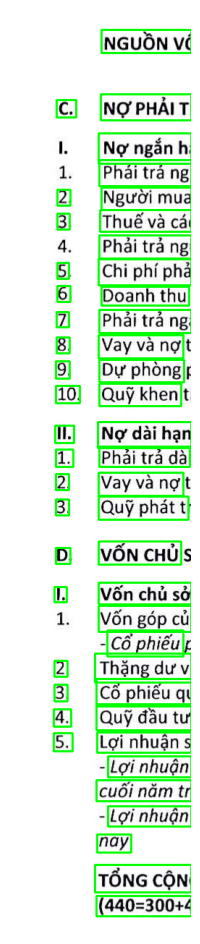

In [ ]:
import cv2
import numpy as np
import easyocr
from matplotlib import pyplot as plt

# Đọc ảnh gốc
path = r'C:\Users\levie\Downloads\ReportFinance\test12\00001646903820816864cng-ty-c-phn-cao-su-sao-vng01032024-101631\00001646903820816864cng-ty-c-phn-cao-su-sao-vng01032024-101631_page_8.jpg'
image = cv2.imread(path)[:, :250]

# === Tiền xử lý ảnh ===

# 1. Chuyển sang grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# 2. Tăng tương phản (có thể điều chỉnh alpha, beta)
contrast = cv2.convertScaleAbs(gray, alpha=1.5, beta=10)

# 3. Làm mịn nhẹ để giảm nhiễu
blur = cv2.GaussianBlur(contrast, (3, 3), 0)

# 4. Tùy chọn: áp dụng threshold để làm rõ chữ (chưa bắt buộc)
# thresh = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
#                                cv2.THRESH_BINARY, 15, 10)

# === Nhận dạng văn bản với EasyOCR ===

reader = easyocr.Reader(['vi', 'en'], verbose=False, gpu= False)

results = reader.readtext(
    blur,  # hoặc thresh nếu bạn threshold
    slope_ths=0.8,
    height_ths=0.7,
    mag_ratio=1.5,
)

# === Vẽ kết quả OCR ===

for (bbox, text, prob) in results:
    bbox = [tuple(map(int, point)) for point in bbox]
    cv2.polylines(image, [np.array(bbox)], isClosed=True, color=(0, 255, 0), thickness=2)
    # Bạn có thể bật dòng dưới để vẽ text nếu muốn
    # cv2.putText(image, text, bbox[0], cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 0, 0), 2)

# Hiển thị ảnh với bounding box
plt.figure(figsize=(12, 12))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()


In [ ]:
path = r'C:\Users\levie\Downloads\ReportFinance\PreprocessImage113\BBM_23CN_BCTC_KT_20022024100309\BBM_23CN_BCTC_KT_20022024100309_page_11.jpg'

Đã lưu ảnh với bounding box tại: result_boxes.jpg


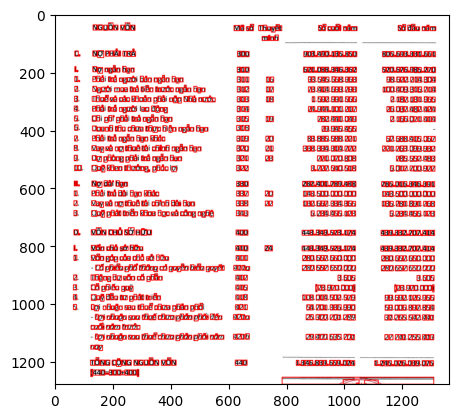

[2025/04/11 17:08:17] ppocr WARNING: Since the angle classifier is not initialized, it will not be used during the forward process


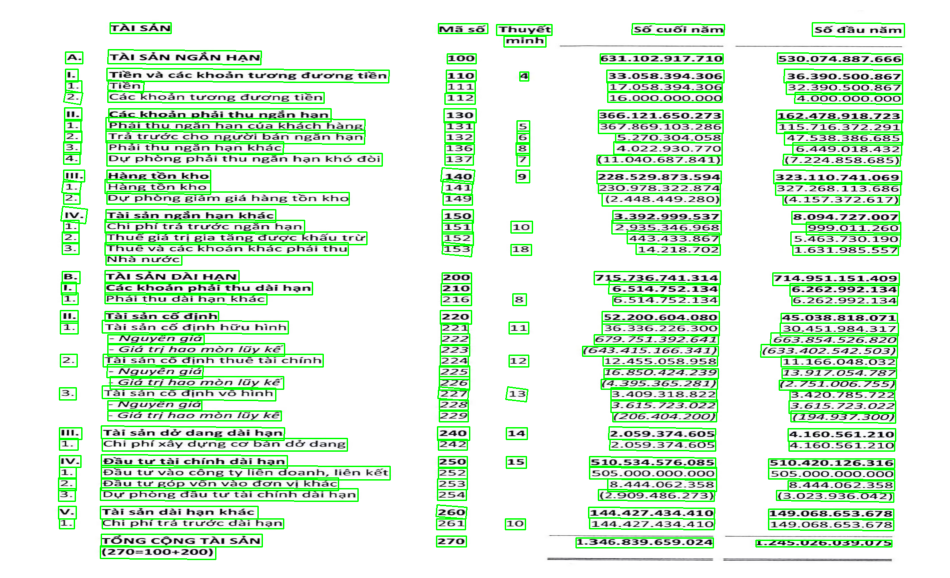

In [ ]:
import cv2
import numpy as np
from paddleocr import PaddleOCR
import matplotlib.pyplot as plt

# 1. Đường dẫn ảnh
img_path = r"C:\Users\levie\Downloads\ReportFinance\test12\00001646903820816864cng-ty-c-phn-cao-su-sao-vng01032024-101631\00001646903820816864cng-ty-c-phn-cao-su-sao-vng01032024-101631_page_7.jpg"

# 2. Khởi tạo OCR
ocr = PaddleOCR(
    # det_lang='ml',
                # det_db_box_thresh=0.1,     # ngưỡng để lọc các box yếu, tăng nếu nhiều box nhiễu
    # det_db_unclip_ratio=0.2,   # độ mở rộng box, giảm nếu box bị chồng
    # use_dilation=False,        # không dùng giãn nở để tránh gộp sai
    # use_angle_cls=False,       # nếu văn bản không bị xoay
    lang='en',                 # nếu dùng rec tiếng Việt
    show_log=False             # tắt log nếu không cần)
)
# 3. Đọc ảnh
image = cv2.imread(img_path)
img = image.copy()
image = cv2.resize(image, (1000 * 2, 1200))


# 4. Chạy OCR
result = ocr.ocr(image, cls=True)

img_vis = image.copy()
for line in result:
    for word_info in line:
        box = np.array(word_info[0]).astype(int)
        cv2.polylines(img_vis, [box], isClosed=True, color=(0, 255, 0), thickness=2)

plt.figure(figsize=(12, 12))
plt.imshow(cv2.cvtColor(img_vis, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [ ]:
import pandas as pd



df = pd.read_csv('file.csv')  # hoặc chỉ 'tenfile.csv' nếu cùng folder
# Nếu muốn làm mọi cột đều là chuỗi (để căn trái dữ liệu)
df = df.astype(str)
# Hiển thị toàn bộ bảng căn trái trong Jupyter
pd.set_option('display.colheader_justify', 'left')  # căn trái tiêu đề
pd.set_option('display.unicode.east_asian_width', True)

df


,Unnamed: 0,TÀI SẢN,Mã số,Thuyết minh,Số cuối năm,Số đầu năm
0,A.,TÀI SẢN NGẮN HẠN,100,631.102.917.710,530.074.887.666,nan
1,1,Tiền và các khoản tương đương tiền,110,4,33.058.394.306,36.390.500.867
2,1.,Tiền,111,17.058.394.306,32.390.500.867,nan
3,2,Các khoản tương đương tiền,112,16.000.000.000,4.000.000.000,nan
4,11.,Các khoản phải thu ngắn hạn,130,366.121.650.273,162.478.918.723,nan
5,1.,Phải thu ngắn hạn của khách hàng,131,5,367.869.103.286,115.716.372.291
6,2.,Trả trước cho người bán ngắn hạn,132,6,5.270.304.058,47.538.386.685
7,3.,Phải thu ngắn hạn khác,136,8,4.022.930.770,6.449.018.432
8,4.,Dự phòng phải thu ngắn hạn khó đòi,137,7,(11.040.687.841),(7.224.858.685)
9,II1.,Hàng tồn kho,140,9,228.529.873.594,323.110.741.069


[2025/04/11 17:24:38] ppocr WARNING: Since the angle classifier is not initialized, it will not be used during the forward process


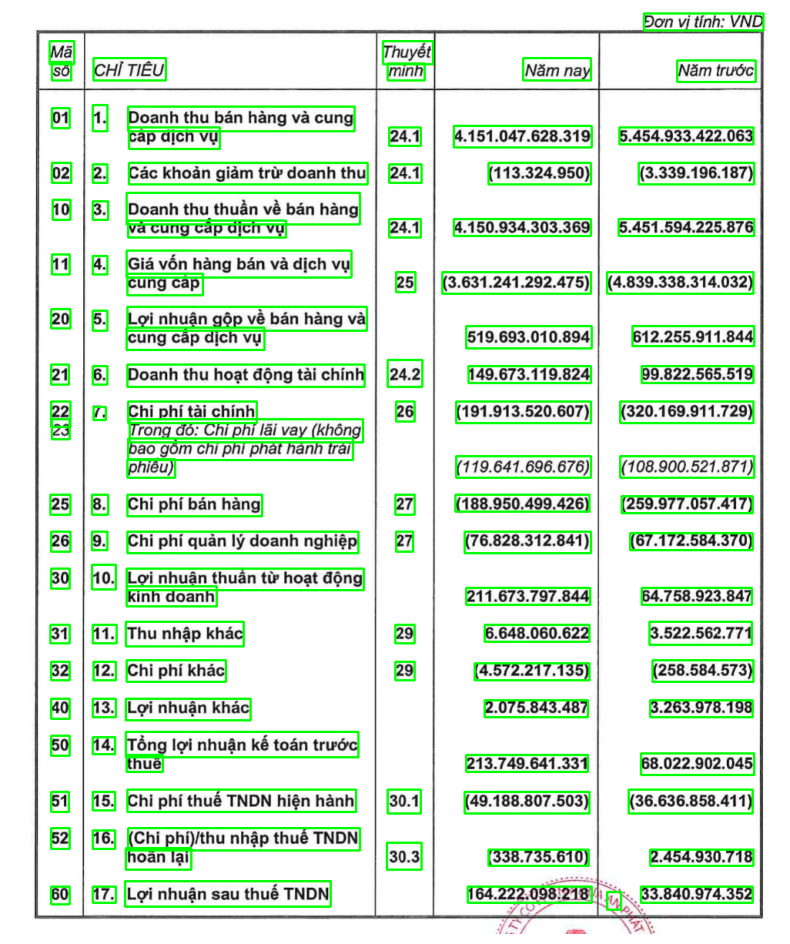

In [ ]:
import cv2
import numpy as np
from paddleocr import PaddleOCR
import matplotlib.pyplot as plt

# 1. Đường dẫn ảnh
img_path = r"C:\Users\levie\Downloads\ReportFinance\test12\0004940711462450593ctcp-nha-an-pht-xanh29032024-224713\0004940711462450593ctcp-nha-an-pht-xanh29032024-224713_page_12.jpg"

def process(img_path):
    # 2. Khởi tạo OCR
    ocr = PaddleOCR(
        # det_lang='ml',
                    # det_db_box_thresh=0.1,     # ngưỡng để lọc các box yếu, tăng nếu nhiều box nhiễu
        # det_db_unclip_ratio=0.2,   # độ mở rộng box, giảm nếu box bị chồng
        # use_dilation=False,        # không dùng giãn nở để tránh gộp sai
        # use_angle_cls=False,       # nếu văn bản không bị xoay
        lang='en',                 # nếu dùng rec tiếng Việt
        show_log=False             # tắt log nếu không cần)
    )

    # 3. Đọc ảnh
    image = cv2.imread(img_path)
    img = image.copy()
    image = cv2.resize(image, (1000 * 2, 1200))
    img = cv2.resize(img, (1000, 1200))

    # 4. Chạy OCR
    result = ocr.ocr(image, cls=True)


    # 1. Lấy bounding box (x1, y1, x2, y2)
    rects = []
    for line in result:
        for word_info in line:
            box = np.array(word_info[0], dtype=np.float32)

            x, y, w, h = cv2.boundingRect(box)
            rects.append([x / 2, y , (x + w) / 2, (y + h)])

    rects = np.array(rects, dtype= int)
    # 6. Vẽ
    for rect in rects:
        x1, y1, x2, y2 = rect
        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)


    # 7. Hiển thị
    plt.figure(figsize=(12, 12))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

process(img_path= img_path)

In [ ]:
import easyocr

In [ ]:
import numpy as np
a = np.array([[1, 2, 3],
              [2, 3, 4]])
a = a * np.array([10, 20, 30])
a

array([[ 10,  40,  90],
       [ 20,  60, 120]])

In [ ]:
img.shape

(1012, 1385, 3)

In [ ]:
def can_merge(r1, r2, x_thresh=10, y_thresh=5):
    x_gap = min(abs(r2[0] - r1[2]), abs(r2[2] - r1[0]))
    y_center_diff = abs((r1[1] + r1[3]) / 2 - (r2[1] + r2[3]) / 2)
    print(x_gap)
    return x_gap < x_thresh 

In [ ]:
can_merge(merged[-6], merged[-5])

10


False

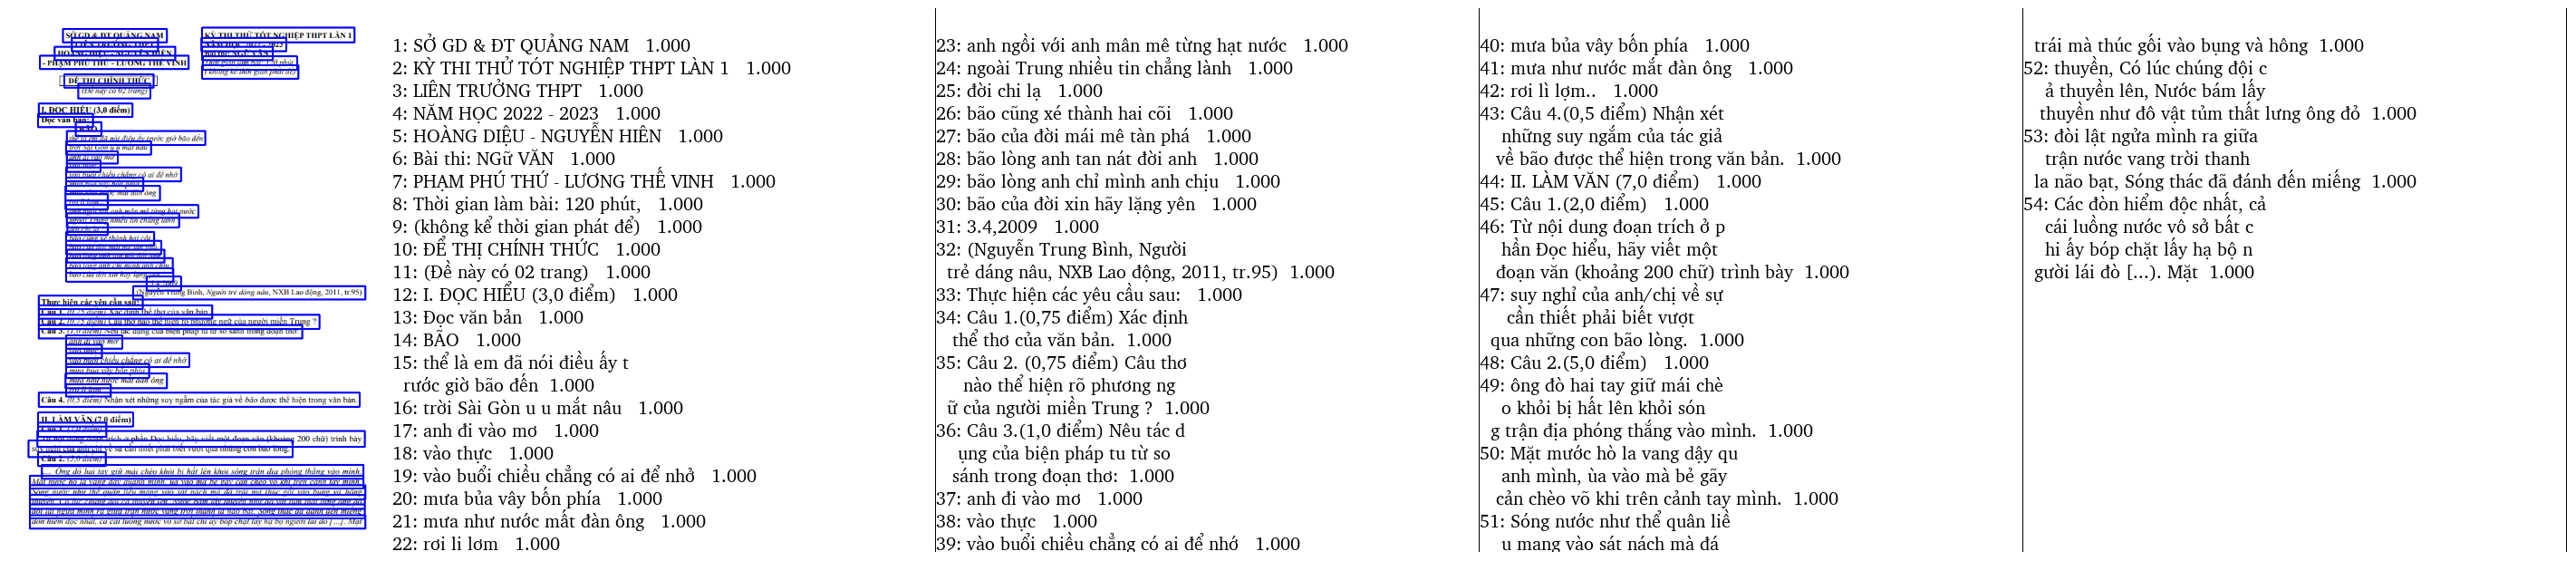

In [ ]:
input_path = 'samples/devanclearn.png'
output_path = './output'

# Predict
boxes, texts = predict(recognitor, detector, input_path, output_path, padding=2, dpi=100)

In [ ]:
# 